# **RoseTTAFold-All-Atom**

**Introduction.**
*   The notebook is still in development.
*   At this moment, a structure from the sequence could be only predicted, with **no_templates** mode.
*   Further calculations require additional libraries and patches from [vorobieva_lab GitHub](https://github.com/Cenoten/vorobieva_lab/tree/main).
*   The **token** obtaining  process instruction is available  [here](https://stackoverflow.com/questions/2505096/clone-a-private-repository-github).

**Important notice**
* ***Run all*** from the first attempt is not supported yet.
* The installation process causes a message saying *Your session crashed for an unknown reason.*
* Do not worry. Just tap **Run all** after this message.





In [1]:
#@title ##Installation required libraries, downloading RFaa2 weights, and applying some patches
#@markdown This step can take up to ~8 mins
%%capture
import os
from google.colab import files
import re
import hashlib
import random

if not os.path.isfile("CONDACOLAB_READY"):
  !pip install -q condacolab
  import condacolab
  condacolab.install()
  os.system("touch CONDACOLAB_READY")

if not os.path.isfile("ADDITIONAL_SOFT"):
  !mamba install -y -c conda-forge -c bioconda -c predector -c pyg -c pytorch -c nvidia -c biocore kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 openbabel=3.1.1  deepdiff=6.7.1 icecream=2.1.3 assertpy=1.1  dgl=1.1.2 pdbfixer
  !mamba install -y openbabel -c conda-forge
  !pip install hydra-core
  !pip install assertpy==1.1
  !pip install icecream
  !pip install biopython==1.79
  import locale
  locale.getpreferredencoding = lambda: "UTF-8"
  %shell pip install -q py3Dmol
  %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py
  os.system("pip install --no-dependencies e3nn==0.3.3 opt_einsum_fx")
  os.system('touch ADDITIONAL_SOFT')

USE_TEMPLATES = False #
if USE_TEMPLATES and not os.path.isfile('USE_TEMPLATES_READY'):
  !conda install bioconda::ffindex
  os.system('touch USE_TEMPLATES_READY')
if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")

if not os.path.isfile('RF2AA_READY'):
  os.system("git clone https://github.com/baker-laboratory/RoseTTAFold-All-Atom.git")
  os.system("cd RoseTTAFold-All-Atom/rf2aa/SE3Transformer; pip install .")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")
  os.system("wget http://files.ipd.uw.edu/pub/RF-All-Atom/weights/RFAA_paper_weights.pt")
  os.system('touch RF2AA_READY')

GitHub_tocken = "your_Token" #@param {type:"string"}

os.system(f'git clone https://{GitHub_tocken}@github.com/Cenoten/vorobieva_lab.git')

from vorobieva_lab.RF2aa_google_colab.add.patch_run import main as patch_run
patch_run()


In [1]:
#@title ##Some preparations
#@markdown ##Input Sequence
import time
time.sleep(25)
import colabfold as cf
import os
sequence = "PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK" #@param {type:"string"}
sequence = sequence.translate(str.maketrans('', '', ' \n\t')).upper()
prefix = cf.get_hash(sequence)
jobname = "test007" #@param {type:"string"}
jobname += "_"+cf.get_hash(sequence)[:5]

import yaml
with open('RoseTTAFold-All-Atom/rf2aa/config/inference/protein.yaml') as f:
    doc = yaml.safe_load(f)
    doc['job_name'] = jobname
    doc['protein_inputs']['A']['fasta_file'] = jobname + "/" + jobname + '.fasta'
with open(f"RoseTTAFold-All-Atom/rf2aa/config/inference/{jobname}.yaml", "w") as new_file:
    yaml.dump(doc, new_file)

if not os.path.exists(jobname):
    os.mkdir(jobname)
with open(f"{jobname}/{jobname}.fasta","w") as fasta:
    fasta.write(f">{jobname}\n{sequence}\n")


In [3]:
#@title Search against genetic databases
#@markdown ---
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence"]


if msa_method == "mmseqs2":
  a3m_lines = cf.run_mmseqs2(sequence, prefix, filter=True)
  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write(a3m_lines)

elif msa_method == "single_sequence":
  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write(f">{jobname}\n{sequence}\n")

os.system(f'mkdir {jobname}/A')
os.system(f'mv {jobname}/msa.a3m {jobname}/A/t000_.msa0.a3m')

0

In [4]:
#@title ## Run RoseTTAFold-All-Atom
import time, sys
if not "IMPORTED" in dir():
  if 'RoseTTAFold-All-Atom/rf2aa' not in sys.path:
    os.environ["DGLBACKEND"] = "pytorch"
    sys.path.append('RoseTTAFold-All-Atom/rf2aa')
    sys.path.append('RoseTTAFold-All-Atom')
from run_inference import ModelRunner
from hydra import compose, initialize
from omegaconf import OmegaConf
try:
  initialize(version_base=None, config_path="RoseTTAFold-All-Atom/rf2aa/config/inference/", job_name=jobname)
except:
  pass
cfg = compose(config_name=jobname)
runner = ModelRunner(cfg)
runner.infer()

/usr/local/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'test007_a5e17': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


Using the cif atom ordering for TRP.
No templates provided


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

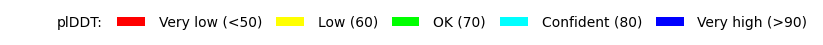

In [5]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import colabfold as cf
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
cf.show_pdb(f"{jobname}.pdb", show_sidechains, show_mainchains, color, chains=1, vmin=0.5, vmax=0.9).show()

if color == "lDDT": cf.plot_plddt_legend().show()

In [ ]:
#@title Download prediction

#@markdown Once this cell has been executed, a predicted structure in **PDB** format

#@markdown will be automatically downloaded  to your computer.
from google.colab import files

files.download(f'{jobname}.pdb')